In [1]:
import os
kaggle_auth = {"username":"kaggleusername","key":"kagglekey"}
os.environ['KAGGLE_USERNAME'] = kaggle_auth["username"]
os.environ['KAGGLE_KEY'] = kaggle_auth["key"]
!kaggle datasets download preetviradiya/brian-tumor-dataset
!pip install timm
!pip install matplotlib
!pip install torcheval

 91% 98.0M/107M [00:01<00:00, 107MB/s]
100% 107M/107M [00:01<00:00, 107MB/s] 
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.0 MB/s eta 0:00:00


In [2]:
import timm
from fastcore.all import *
from fastai.vision.all import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
from torcheval.metrics import MulticlassAccuracy, BinaryAUPRC, BinaryPrecision, BinaryRecall
import gc

In [3]:
with zipfile.ZipFile('brian-tumor-dataset.zip', 'r') as zip_ref:
  zip_ref.extractall()

In [19]:
# Constants
BATCH_SIZE = 64
NUM_OF_EPOCHS = 10
MODEL_NAME = "efficientnet_b0"
base_model_output_size = 1280
LEARNING_RATE = 0.001
DROPOUT_PROB = 0.3
DATASET_PATH = "Brain Tumor Data Set/Brain Tumor Data Set"
IMG_HEIGHT_WIDTH = 128

In [20]:
class BrainTumorDataset(Dataset):
  def __init__(self, data_directory, transform=None):
    self.data = ImageFolder(data_directory, transform=transform)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    return self.data[index]

  @property
  def classes(self):
    return self.data.classes

In [21]:
transform = transforms.Compose([transforms.Resize((IMG_HEIGHT_WIDTH, IMG_HEIGHT_WIDTH)), transforms.ToTensor()])

dataset = BrainTumorDataset(Path(DATASET_PATH), transform)

indexes_to_classes = {v: k for k, v in ImageFolder(Path(DATASET_PATH)).class_to_idx.items()}

for image, label in dataset:
  break

image.shape # [image_dimensions, image_height, image_width]

torch.Size([3, 128, 128])

In [22]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for images, labels in dataloader:
  break

images.shape, labels.shape # [batch_size, image_dimensions, image_height, image_width]

(torch.Size([64, 3, 128, 128]), torch.Size([64]))

In [23]:
class BrainTumorClassifierPreTrainedFineTunedCNN(nn.Module):
  def __init__(self, number_of_classes):
    super(BrainTumorClassifierPreTrainedFineTunedCNN, self).__init__()

    # Where we define all the parts of the model
    self.base_model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=0)

    # making our last layer (the classifier)
    self.classifier =  nn.Sequential(nn.Dropout(p=DROPOUT_PROB), nn.Linear(base_model_output_size, number_of_classes))

  def forward(self, x):
    # Connect these parts and return the output
    x = self.base_model(x)
    output = self.classifier(x)
    return output

In [24]:
class BrainTumorClassifierNotPreTrainedFineTunedCNN(nn.Module):
  def __init__(self, number_of_classes):
    super(BrainTumorClassifierNotPreTrainedFineTunedCNN, self).__init__()

    # Where we define all the parts of the model
    self.base_model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=0)

    # making our last layer (the classifier)
    self.classifier =  nn.Sequential(nn.Dropout(p=DROPOUT_PROB), nn.Linear(base_model_output_size, number_of_classes))

  def forward(self, x):
    # Connect these parts and return the output
    x = self.base_model(x)
    output = self.classifier(x)
    return output

In [25]:
class BrainTumorClassifierCNN(nn.Module):
  def __init__(self, number_of_classes):
    super(BrainTumorClassifierCNN, self).__init__()

    self.layer1 = nn.Conv2d(3, 8, stride=2, kernel_size=3)
    self.layer1_norm = nn.BatchNorm2d(8)
    self.layer1_activation = nn.ReLU()

    self.layer2 = nn.Conv2d(8, 16, stride=2, kernel_size=3)
    self.layer2_norm = nn.BatchNorm2d(16)
    self.layer2_activation = nn.ReLU()

    self.layer3 = nn.Conv2d(16, 32, stride=2, kernel_size=3)
    self.layer3_norm = nn.BatchNorm2d(32)
    self.layer3_activation = nn.ReLU()

    self.layer4 = nn.Conv2d(32, 2, stride=2, kernel_size=3)
    self.layer5 = nn.Flatten()

  def forward(self, x):
    # Connect these parts and return the output
    layer1_output = self.layer1_activation(self.layer1_norm(self.layer1(x)))
    layer2_output = self.layer2_activation(self.layer2_norm(self.layer2(layer1_output)))
    layer3_output = self.layer3_activation(self.layer3_norm(self.layer3(layer2_output)))
    layer4_output = self.layer4(layer3_output)
    output = self.layer5(layer4_output)
    return output

In [26]:
class BrainTumorClassifierMLP(nn.Module):
  def __init__(self, number_of_classes):
    super(BrainTumorClassifierMLP, self).__init__()
    inital_input_size = 3 * IMG_HEIGHT_WIDTH * IMG_HEIGHT_WIDTH
    inital_output_size = IMG_HEIGHT_WIDTH // 3
    self.first_linear = nn.Linear(inital_input_size, inital_output_size)
    self.first_layer_activation = nn.ReLU()
    self.second_linear = nn.Linear(inital_output_size, inital_output_size//4)
    self.second_layer_activation = nn.ReLU()
    self.third_linear = nn.Linear(inital_output_size//4, inital_output_size//8)
    self.third_layer_activation = nn.ReLU()
    self.fourth_linear = nn.Linear(inital_output_size//8, number_of_classes)

  def forward(self, x):
    # Connect the parts and return the output
    x = x.view(x.size(0), -1)
    first_layer = self.first_linear(x)
    first_activation = self.first_layer_activation(first_layer)
    second_layer = self.second_linear(first_activation)
    second_activation = self.second_layer_activation(second_layer)
    third_layer = self.third_linear(second_activation)
    third_activation = self.third_layer_activation(third_layer)
    output = self.fourth_linear(third_activation)
    return output

In [27]:
class BrainTumorClassifierLinearRegression(nn.Module):
  def __init__(self, number_of_classes):
    super(BrainTumorClassifierLinearRegression, self).__init__()

    self.linear =  nn.Linear((3 * IMG_HEIGHT_WIDTH * IMG_HEIGHT_WIDTH), number_of_classes)

  def forward(self, x):
    # Connect the parts and return the output
    x = x.view(x.size(0), -1)
    output = self.linear(x)
    return output

In [28]:
models = [BrainTumorClassifierPreTrainedFineTunedCNN(len(indexes_to_classes)), BrainTumorClassifierNotPreTrainedFineTunedCNN(len(indexes_to_classes)), BrainTumorClassifierCNN(len(indexes_to_classes)), BrainTumorClassifierMLP(len(indexes_to_classes)), BrainTumorClassifierLinearRegression(len(indexes_to_classes))]

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Start trainging model: BrainTumorClassifierPreTrainedFineTunedCNN
Base line loss: 0.750, accuracy: 0.46739131212234497, precision: 0.46242332458496094, recall: 0.9466248154640198, auprc: 0.4623790681362152
Epoch 1/10 - Train loss: 0.170, Validation loss: 0.485
Train acc - 0.9313664436340332, valid acc - 0.7746376991271973
auprc - 0.6720741987228394, precision - 0.6734042763710022, recall - 0.9937205910682678
Epoch 2/10 - Train loss: 0.042, Validation loss: 0.055
Train acc - 0.9881987571716309, valid acc - 0.9847826361656189
auprc - 0.9786899089813232, precision - 0.9920127987861633, recall - 0.9748822450637817
Epoch 3/10 - Train loss: 0.029, Validation loss: 0.070
Train acc - 0.9885092973709106, valid acc - 0.9818840622901917
auprc - 0.9692053198814392, precision - 0.9781249761581421, recall - 0.9827315807342529
Epoch 4/10 - Train loss: 0.046, Validation loss: 0.070
Train acc - 0.9838509559631348, valid acc - 0.9833333492279053
auprc - 0.9756099581718445, precision - 0.9888535141944885

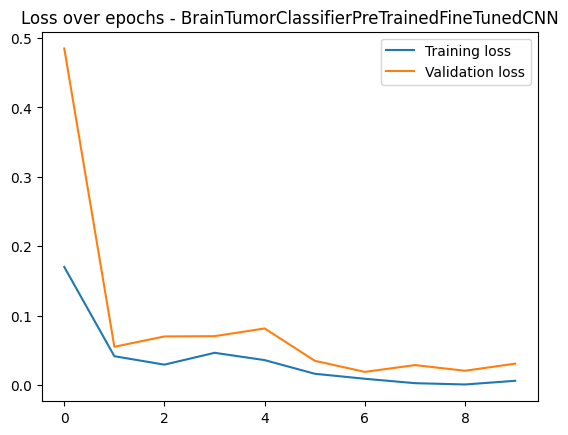




Start trainging model: BrainTumorClassifierNotPreTrainedFineTunedCNN
Base line loss: 0.695, accuracy: 0.458695650100708, precision: 0.458695650100708, recall: 1.0, auprc: 0.458695650100708
Epoch 1/10 - Train loss: 0.604, Validation loss: 0.746
Train acc - 0.6711180210113525, valid acc - 0.6217391490936279
auprc - 0.5364173054695129, precision - 0.7681159377098083, recall - 0.2511848211288452
Epoch 2/10 - Train loss: 0.230, Validation loss: 0.242
Train acc - 0.9130434989929199, valid acc - 0.908695638179779
auprc - 0.8486626744270325, precision - 0.8777943253517151, recall - 0.930489718914032
Epoch 3/10 - Train loss: 0.070, Validation loss: 0.451
Train acc - 0.9745341539382935, valid acc - 0.8673912882804871
auprc - 0.8168246746063232, precision - 0.9166666865348816, recall - 0.7819905281066895
Epoch 4/10 - Train loss: 0.067, Validation loss: 0.330
Train acc - 0.9773291945457458, valid acc - 0.9028985500335693
auprc - 0.8745784759521484, precision - 0.9698681831359863, recall - 0.813

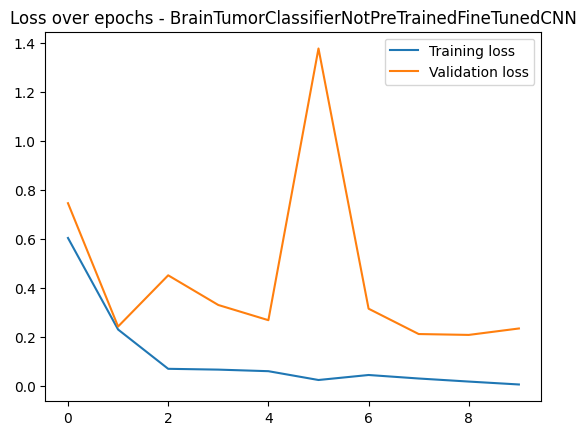




Start trainging model: BrainTumorClassifierCNN
Base line loss: 4.578, accuracy: 0.008695651777088642, precision: 0.45593589544296265, recall: 0.9968152642250061, auprc: 0.46106573939323425
Epoch 1/10 - Train loss: 2.151, Validation loss: 1.594
Train acc - 0.47608694434165955, valid acc - 0.530434787273407
auprc - 0.48916521668434143, precision - 0.5519590973854065, recall - 0.5159235596656799
Epoch 2/10 - Train loss: 1.241, Validation loss: 1.192
Train acc - 0.5636646151542664, valid acc - 0.5942028760910034
auprc - 0.516322135925293, precision - 0.5802861452102661, recall - 0.581210196018219
Epoch 3/10 - Train loss: 1.109, Validation loss: 1.089
Train acc - 0.5931677222251892, valid acc - 0.6144927740097046
auprc - 0.5362429618835449, precision - 0.5769230723381042, recall - 0.7882165312767029
Epoch 4/10 - Train loss: 0.961, Validation loss: 0.966
Train acc - 0.6394410133361816, valid acc - 0.6528985500335693
auprc - 0.5684926509857178, precision - 0.6352112889289856, recall - 0.71

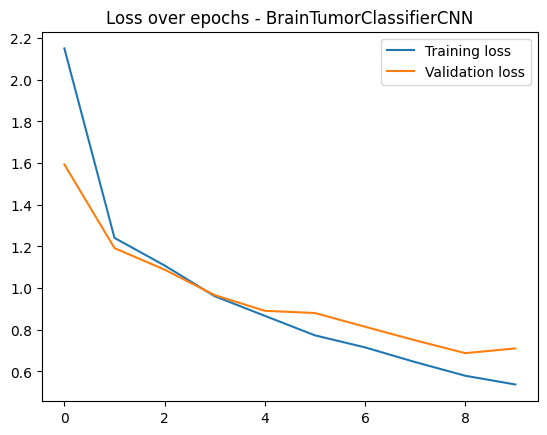




Start trainging model: BrainTumorClassifierMLP
Base line loss: 0.690, accuracy: 0.5514492988586426, precision: 0.0, recall: 0.0, auprc: 0.4485507309436798
Epoch 1/10 - Train loss: 0.657, Validation loss: 0.593
Train acc - 0.6015527844429016, valid acc - 0.6355072259902954
auprc - 0.5353101491928101, precision - 0.590624988079071, recall - 0.6106623411178589
Epoch 2/10 - Train loss: 0.565, Validation loss: 0.540
Train acc - 0.7223602533340454, valid acc - 0.7746376991271973
auprc - 0.701043963432312, precision - 0.8989637494087219, recall - 0.5605815649032593
Epoch 3/10 - Train loss: 0.495, Validation loss: 0.550
Train acc - 0.7878881692886353, valid acc - 0.7239130139350891
auprc - 0.6163097620010376, precision - 0.6525641083717346, recall - 0.8222939968109131
Epoch 4/10 - Train loss: 0.459, Validation loss: 0.448
Train acc - 0.7981366515159607, valid acc - 0.8072463870048523
auprc - 0.7135494351387024, precision - 0.7888706922531128, recall - 0.7786752581596375
Epoch 5/10 - Train l

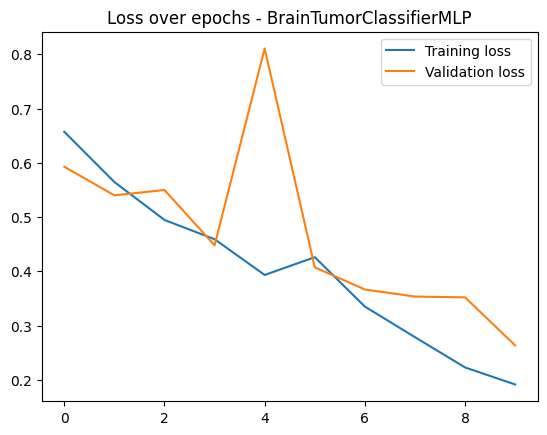




Start trainging model: BrainTumorClassifierLinearRegression
Base line loss: 0.698, accuracy: 0.4739130437374115, precision: 0.3900226652622223, recall: 0.27344992756843567, auprc: 0.43781110644340515
Epoch 1/10 - Train loss: 1.867, Validation loss: 0.647
Train acc - 0.6329192519187927, valid acc - 0.741304337978363
auprc - 0.6593115329742432, precision - 0.8300970792770386, recall - 0.5437201857566833
Epoch 2/10 - Train loss: 0.644, Validation loss: 1.009
Train acc - 0.7381987571716309, valid acc - 0.6217391490936279
auprc - 0.5448412299156189, precision - 0.5486806035041809, recall - 0.9586645364761353
Epoch 3/10 - Train loss: 0.512, Validation loss: 0.529
Train acc - 0.7881987690925598, valid acc - 0.791304349899292
auprc - 0.6916213631629944, precision - 0.7294750809669495, recall - 0.8616852164268494
Epoch 4/10 - Train loss: 0.349, Validation loss: 1.666
Train acc - 0.8574534058570862, valid acc - 0.5101449489593506
auprc - 0.4817153811454773, precision - 0.4818812608718872, rec

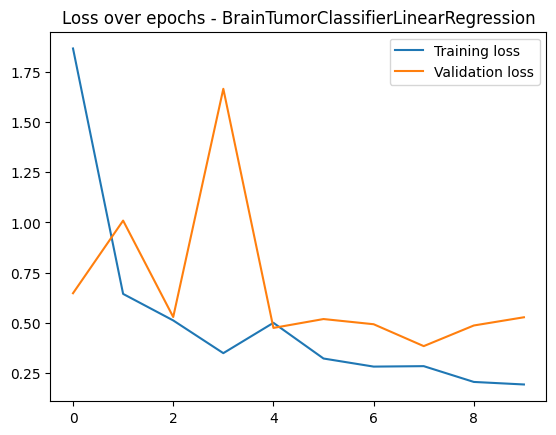

In [30]:

for model in models:
  print(f"Start trainging model: {type(model).__name__}")

  # Loss function
  loss_function = nn.CrossEntropyLoss()

  # Optimizer
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

  # Creating training and validation dataloaders
  training_set_length = (int) (len(dataset) * 0.7)
  validation_set_length = len(dataset) - training_set_length

  training_set, validation_set = torch.utils.data.random_split(dataset, [training_set_length, validation_set_length])

  training_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
  validation_loader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False)
  test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

  train_losses, val_losses = [], []

  model.to(device)

  # Baseline of the model:

  base_line_loss = []
  base_line_metric = MulticlassAccuracy()
  base_line_auprc = BinaryAUPRC()
  base_line_precision = BinaryPrecision()
  base_line_recall = BinaryRecall()

  model.eval()
  base_line_running_loss = 0.0
  with torch.no_grad():
    for images, labels in validation_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = loss_function(outputs, labels)
      base_line_metric.update(outputs.argmax(1), labels)
      base_line_auprc.update(outputs.argmax(1), labels)
      base_line_precision.update(outputs.argmax(1), labels)
      base_line_recall.update(outputs.argmax(1), labels)
      base_line_running_loss += loss.item() * images.size(0)

  base_line_loss = base_line_running_loss / len(validation_loader.dataset)

  print(f"Base line loss: {base_line_loss:.3f}, accuracy: {base_line_metric.compute()}, precision: {base_line_precision.compute()}, recall: {base_line_recall.compute()}, auprc: {base_line_auprc.compute()}")

  # Training Loop
  for epoch in range(NUM_OF_EPOCHS):
    # Set the model to train
    model.train()
    train_metric = MulticlassAccuracy()
    valid_metric = MulticlassAccuracy()
    auprc = BinaryAUPRC()
    precision = BinaryPrecision()
    recall = BinaryRecall()

    running_loss = 0.0
    for images, labels in training_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = loss_function(outputs, labels)
      train_metric.update(outputs.argmax(1), labels)
      loss.backward()
      optimizer.step()
      # print(f"loss.item()={loss.item()}, images.size(0)={images.size(0)}")
      running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(training_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase in the epoch
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in validation_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = loss_function(outputs, labels)
          valid_metric.update(outputs.argmax(1), labels)
          auprc.update(outputs.argmax(1), labels)
          precision.update(outputs.argmax(1), labels)
          recall.update(outputs.argmax(1), labels)
          running_loss += loss.item() * images.size(0)

    validation_loss = running_loss / len(validation_loader.dataset)
    val_losses.append(validation_loss)

    # Print epoch stats
    print(f"Epoch {epoch+1}/{NUM_OF_EPOCHS} - Train loss: {train_loss:.3f}, Validation loss: {validation_loss:.3f}")
    print(f"Train acc - {train_metric.compute()}, valid acc - {valid_metric.compute()}")
    print(f"auprc - {auprc.compute()}, precision - {precision.compute()}, recall - {recall.compute()}")

  plt.plot(train_losses, label='Training loss')
  plt.plot(val_losses, label='Validation loss')
  plt.legend()
  plt.title(f"Loss over epochs - {type(model).__name__}")
  plt.show()

  torch.cuda.empty_cache()
  gc.collect()
  print("\n\n")